In [1]:
import numpy as np
import pandas as pd
import emoji
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN,LSTM, Activation
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./Desktop/DataFlair/train.csv',header=None)
test = pd.read_csv('./Desktop/DataFlair/test.csv',header=None)

In [3]:
train.head()

,0,1,2,3
0,never talk to me again,3,NaN,NaN
1,I am proud of your achievements,2,NaN,NaN
2,It is the worst day in my life,3,NaN,NaN
3,Miss you so much,0,NaN,[0]
4,food is life,4,NaN,NaN


In [4]:
test.head()

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


In [5]:
emoji_dict = { 0 : ":heart:", 1 : ":baseball:", 2 : ":smile:", 3 : ":disappointed:", 4 : ":fork_and_knife:"}

In [6]:
for ix in emoji_dict.keys():
    print (ix,end=" ")
    print (emoji.emojize(emoji_dict[ix], use_aliases=True))

0 ❤
1 ⚾
2 😄
3 😞
4 🍴


In [7]:
# Creating training and testing data
X_train = train[0]
Y_train = train[1]

X_test = test[0]
Y_test = test[1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(132,) (132,) (56,) (56,)


In [8]:
for ix in range(X_train.shape[0]):
    X_train[ix] = X_train[ix].split()

for ix in range(X_test.shape[0]):
    X_test[ix] = X_test[ix].split()
    
Y_train = to_categorical(Y_train)

<ipython-input-8-f1bc63141b06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[ix] = X_train[ix].split()
<ipython-input-8-f1bc63141b06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[ix] = X_test[ix].split()


In [9]:
# Now checking the above conversion by printing train and test data at 0th index
print (X_train[0],Y_train[0])

['never', 'talk', 'to', 'me', 'again'] [0. 0. 0. 1. 0.]


In [10]:
np.unique(np.array([len(ix) for ix in X_train]) , return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 4,  5, 26, 35, 20, 21, 11,  5,  1,  4], dtype=int64))

In [11]:
np.unique(np.array([len(ix) for ix in X_test]) , return_counts=True)

(array([2, 3, 4, 5, 6, 7, 8]),
 array([ 3, 12, 16, 17,  3,  4,  1], dtype=int64))

In [12]:
embeddings_index = {}

f = open('./glove.6B.50d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
# Checking length of a particular word
embeddings_index["i"].shape

(50,)

In [14]:
from scipy import spatial
# Checking cosine similarity of words happy and sad
spatial.distance.cosine(embeddings_index["happy"], embeddings_index["sad"])

0.31093674898147583

In [15]:
# Checking cosine similarity of words India and Delhi
spatial.distance.cosine(embeddings_index["india"], embeddings_index["delhi"])

0.18572336435317993

In [16]:
# Checking cosine similarity of words france and paris
spatial.distance.cosine(embeddings_index["france"], embeddings_index["paris"])

0.19746702909469604

In [17]:
# Filling the embedding matrix
embedding_matrix_train = np.zeros((X_train.shape[0], 10, 50))
embedding_matrix_test = np.zeros((X_test.shape[0], 10, 50))

for ix in range(X_train.shape[0]):
    for ij in range(len(X_train[ix])):
        embedding_matrix_train[ix][ij] = embeddings_index[X_train[ix][ij].lower()]
        
for ix in range(X_test.shape[0]):
    for ij in range(len(X_test[ix])):
        embedding_matrix_test[ix][ij] = embeddings_index[X_test[ix][ij].lower()]        

In [18]:
print (embedding_matrix_train.shape, embedding_matrix_test.shape)

(132, 10, 50) (56, 10, 50)


In [19]:
# A simple LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(10,50), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 223,877
Trainable params: 223,877
Non-trainable params: 0
__________________________________________________

In [20]:
# Setting Loss ,Optimiser for model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Training model
hist = model.fit(embedding_matrix_train,
                 Y_train,
                 epochs = 50, 
                 batch_size=32,
                 shuffle=True
                )

Epoch 1/50
5/5 [==============================] - 0s 14ms/step - loss: 1.5205 - accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 1.4575 - accuracy: 0.4015
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 1.4274 - accuracy: 0.4697
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 1.3094 - accuracy: 0.5606
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 1.1949 - accuracy: 0.5530
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0952 - accuracy: 0.6061
Epoch 7/50
5/5 [==============================] - 0s 14ms/step - loss: 1.0162 - accuracy: 0.5758
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 0.8851 - accuracy: 0.6667
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7475 - accuracy: 0.7424
Epoch 10/50
5/5 [==============================] - 0s 14ms/step - loss: 0.7013 - accuracy: 0.7424
Epoch 11/50
5/5 [============

In [23]:
# Prediction of trained model
pred = model.predict_classes(embedding_matrix_test)
# print(emoji.emojize(emoji_dict[pred[0]]))

C:\Users\HP\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### ACCURACY

In [24]:
# Calculating accuracy / score  of the model
float(sum(pred==Y_test))/embedding_matrix_test.shape[0]

0.6785714285714286

In [25]:
# Printing the sentences with the predicted and the labelled emoji
for ix in range(embedding_matrix_test.shape[0]):
    
    if pred[ix] != Y_test[ix]:
        print(ix)
        print (test[0][ix],end=" ")
        print (emoji.emojize(emoji_dict[pred[ix]], use_aliases=True),end=" ")
        print (emoji.emojize(emoji_dict[Y_test[ix]], use_aliases=True))

6
['I', 'am', 'upset'] 😞 ❤
7
['We', 'had', 'such', 'a', 'lovely', 'dinner', 'tonight'] 😄 ❤
11
['work', 'is', 'hard'] 😄 😞
12
['This', 'girl', 'is', 'messing', 'with', 'me'] ❤ 😞
13
['are', 'you', 'serious', 'ha', 'ha'] 😞 😄
21
['you', 'brighten', 'my', 'day'] ❤ 😄
23
['she', 'is', 'a', 'bully'] ❤ 😞
26
['I', 'worked', 'during', 'my', 'birthday'] 😄 😞
28
['enjoy', 'your', 'break'] ⚾ 😄
29
['valentine', 'day', 'is', 'near'] 😄 ❤
32
['My', 'life', 'is', 'so', 'boring'] ❤ 😞
34
['will', 'you', 'be', 'my', 'valentine'] 😄 ❤
40
['I', 'will', 'go', 'dance'] ⚾ 😄
41
['I', 'like', 'your', 'jacket'] ❤ 😄
48
['I', 'want', 'to', 'joke'] 😞 😄
49
['go', 'away'] ⚾ 😞
50
['yesterday', 'we', 'lost', 'again'] ⚾ 😞
55
['I', 'did', 'not', 'have', 'breakfast'] 🍴 😞


In [26]:
# The below function is directly taken from the scikit-learn website to plot the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [27]:
conf_matrix = confusion_matrix(Y_test, pred)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[ 8  0  3  1  0]
 [ 0  5  0  0  0]
 [ 2  2 12  2  0]
 [ 3  2  2  7  1]
 [ 0  0  0  0  6]]


Confusion matrix, without normalization


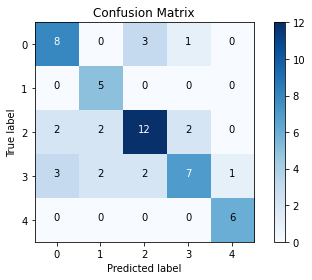

In [28]:
plot_confusion_matrix(conf_matrix, classes = [0, 1, 2, 3, 4], title = "Confusion Matrix")

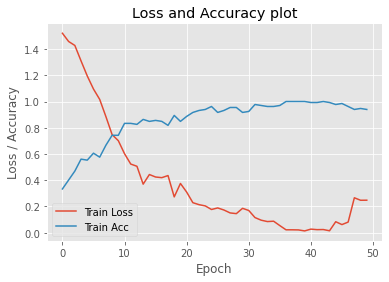

In [29]:
epochs = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), hist.history["loss"], label = "Train Loss")
plt.plot(np.arange(0, epochs), hist.history["accuracy"], label = "Train Acc")

plt.title("Loss and Accuracy plot")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.jpg")